# Visualizing Unit Quality Metrics

This content is taken and adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html). Further explanation for each metric can be there.

This Jupyter notebook will provide a detailed explanation of the unit quality metrics included in ecephys NWB Files. It's important to pay attention to quality metrics, because failing to apply them correctly could lead to invalid scientific conclusions, or could end up hiding potentially useful data. To help you avoid these pitfalls, this tutorial will explore how these metrics are calculated, how they can be biased, and how they should be applied to specific use cases. It's important to keep in mind that none of these metrics are perfect, and that the use of unit quality metrics for filtering ephys data is still an evolving area of research. More work is required in order to establish general-purpose best practices and standards in this domain.

All of the Allen Institute Neuropixels data has been sorted with [Kilosort2](https://github.com/MouseLand/Kilosort), a template-matching algorithm developed by Marius Pachitariu at HHMI Janelia Research Campus. Because there is no "ground truth" information available in these datasets, any sorting algorithm is bound to make mistakes. Quality metrics allow us to understand the types of mistakes that are occurring, and obtain an estimate of their severity. Some common errors that can be identified by quality metrics include:
- Assigning spikes from multiple neurons to the same cluster
- Missing spikes from neurons with waveform amplitude near the spike detection threshold
- Failing to track neurons with waveforms that change as a result of electrode drift


These mistakes can occur even in units that appear to be extremely well isolated. It's misleading to conceive of units as existing in two distinct categories, one with perfectly clean "single units" and one with impure "multiunits." Instead, there's a gradient of qualities, with mostly complete, uncontaminated units at one end, and incomplete, highly contaminated units at the other.

Despite the fact that there's not a clear division between single-unit and multi-unit activity, we still have to make a binary decision in every analysis we carry out: should this unit be included or not? Ideally this decision should be based on objective metrics that will not bias the end results. By default, the AllenSDK uses three quality metrics, isi_violations, amplitude_cutoff, and presence_ratio, to filter out units that are likely to be highly contaminated or missing lots of spikes. However, the default values of these filters may not be appropriate for your analysis, or you may want to disable them entirely. Reading through this tutorial will give you a better understanding of how these (and other) metrics should be applied, so you can apply them effectively throughout your own explorations of this dataset.

### Environment Setup

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from pynwb import NWBHDF5IO

%matplotlib inline

### Downloading an NWB File
If you don't already have a file to analyze, you can use a file from The Allen Institute's `Visual Coding - Neuropixels` dataset. If you want to choose your own file to download, set `dandiset_id` and `dandi_filepath` accordingly.

In [ ]:
dandiset_id = "000021"
dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"
download_loc = "."

In [ ]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [ ]:
my_dandiset = dandiapi.DandiAPIClient().get_dandiset(dandiset_id)
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

### Reading a Stimulus File

In [2]:
stim_filepath = f"../../../data/visual_coding/sub-699733573_ses-715093703.nwb"
stim_io = NWBHDF5IO(stim_filepath, mode="r", load_namespaces=True)
stim_file = stim_io.read() 
units = stim_file.units.to_dataframe()
units

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


,snr,quality,presence_ratio,spread,cumulative_drift,isolation_distance,amplitude,firing_rate,nn_hit_rate,isi_violations,...,waveform_duration,local_index,max_drift,velocity_above,cluster_id,peak_channel_id,d_prime,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950922146,2.276506,good,0.99,40.0,262.59,48.682817,173.555850,3.534362,0.951456,0.040655,...,0.480737,7,24.71,-1.922948,7,850261194,5.529560,"[31.490034958356276, 32.92370245071491, 35.505...","[0.0001615638969686343, 0.0001146743934257875,...","[[0.0, -0.16964999999999364, 0.642329999999995..."
950922020,2.451651,good,0.99,60.0,313.14,30.717576,114.493860,4.218833,0.844371,0.116510,...,0.563149,1,15.30,-0.529792,1,850261194,2.341324,"[27.189465814863283, 27.352032575157004, 27.41...","[0.0001779263088556941, 0.0001903679273326421,...","[[0.0, -0.8997299999999999, -0.872429999999994..."
950921996,2.556012,good,0.99,30.0,299.83,39.067902,102.989640,6.499649,0.904659,0.105187,...,0.535678,0,20.02,0.343384,0,850261194,3.750008,"[26.971165689137713, 27.075865749437607, 27.10...","[0.0001381400932624782, 0.000185573120709172, ...","[[0.0, 2.752229999999992, 0.5171399999999995, ..."
950922084,1.847681,good,0.99,40.0,460.51,21.987697,143.749710,3.715021,0.553741,1.181287,...,0.631826,4,30.47,0.206030,4,850261196,2.192356,"[27.442999294214125, 27.739099464747063, 27.91...","[0.0001200643878712399, 0.00011509520337930783...","[[0.0, 0.5342999999999982, 0.10296000000000127..."
950922063,1.856763,good,0.99,40.0,266.38,47.741669,140.450700,8.389565,0.902000,0.312214,...,0.590620,3,9.71,-0.686767,3,850261196,3.256906,"[27.284332536166527, 27.39949926916116, 27.456...","[0.000126385992005961, 0.00018898987536720963,...","[[0.0, -0.21762000000000725, -1.52996999999998..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950912625,1.783778,good,0.99,120.0,293.61,58.855195,52.546455,2.158057,0.926667,0.751051,...,1.689447,260,26.27,-0.019622,261,850264748,3.499737,"[29.44196426953433, 29.903998361251567, 30.051...","[7.312737863130707e-05, 7.212584164901977e-05,...","[[0.0, -0.2886000000000628, -0.334035000000056..."
950912613,3.675548,noise,0.95,40.0,52.61,107.547908,142.094355,0.196325,0.996032,0.000000,...,0.123618,259,21.89,1.373534,260,850264748,8.979402,"[73.9129372642996, 74.18597104579126, 74.64837...","[0.00019435351889221552, 0.0002024301302557703...","[[0.0, 1.5533699999999797, 3.8777699999999804,..."
950912583,2.768432,good,0.99,50.0,239.25,78.341831,83.281965,4.707246,0.984667,0.755736,...,0.645561,256,18.30,0.686767,257,850264748,4.122820,"[42.61581922646583, 51.72810085005413, 51.8613...","[7.723552532364613e-05, 8.877822503071246e-05,...","[[0.0, -0.772980000000075, -2.6371800000000114..."


### Firing Rate
*Firing rate* is equal to the total number of spikes divided by the number of seconds in the recording. Below is a density plot of firing rate across all units in the dataset as well as a log-scaled version.

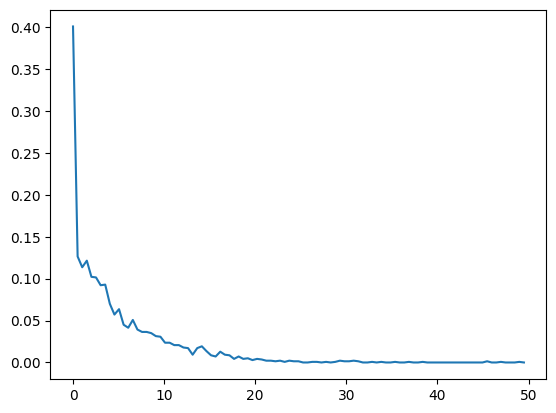

In [84]:
data = units['firing_rate']
bins = np.linspace(0,50,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

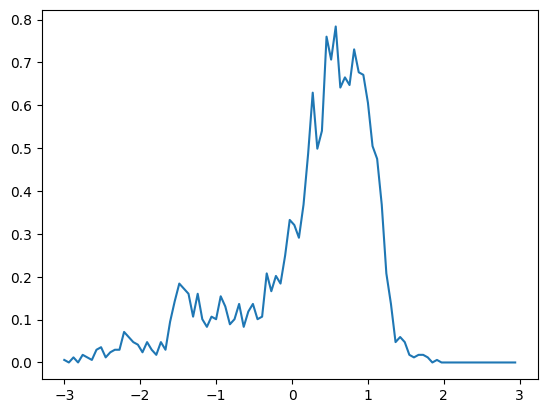

In [85]:
data = np.log10(units['firing_rate'])
bins = np.linspace(-3,3,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### Presence Ratio
*Presence ratio* measures the fraction of time during a session in which a unit is spiking, and ranges from 0 to 0.99. This can be helpful for detecting units that drift out of the recording during a session.

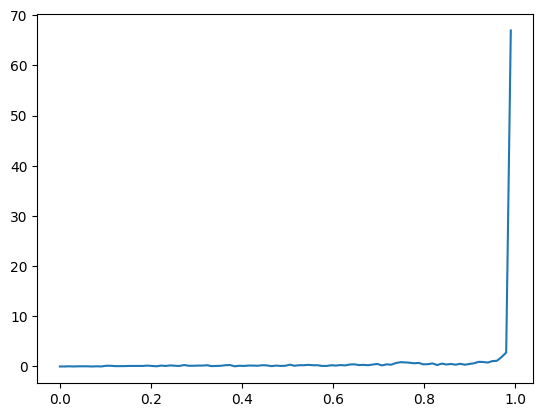

In [86]:
data = units['presence_ratio']
bins = np.linspace(0,1,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### Amplitude Cutoff
*Amplitude cutoff* is a way to check for units that are missing spikes. Unlike presence ratio, which can detect units that drift out of the recording, amplitude cutoff provides an estimate of the false negative rate—e.g., the fraction of spikes below the spike detection threshold. Thus, amplitude cutoff is a measure of unit "completeness" that is complementary to presence ratio.

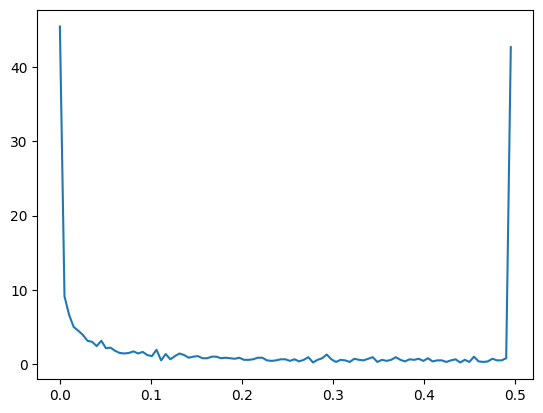

In [118]:
data = units['amplitude_cutoff']
bins = np.linspace(0,0.5,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### ISI Violations
*Inter-spike-interval violations* are a classic measure of unit contamination. Because all neurons have a biophysical refractory period, we can assume that any spikes occurring in rapid succession (<1.5 ms intervals) come from two different neurons. Therefore, the more a unit is contaminated by spikes from multiple neurons, the higher its isi_violations value will be.

The calculation for ISI violations comes from Hill et al. (2011) J Neurosci 31: 8699-8705. Rather than reporting the fraction of spikes with ISI violations, their metric reports the relative firing rate of the hypothetical neurons that are generating these violations. You can interpret an ISI violations value of 0.5 as meaning that contamining spikes are occurring at roughly half the rate of "true" spikes for that unit. In cases of highly contaminated units, the ISI violations value can sometimes be even greater than 1.

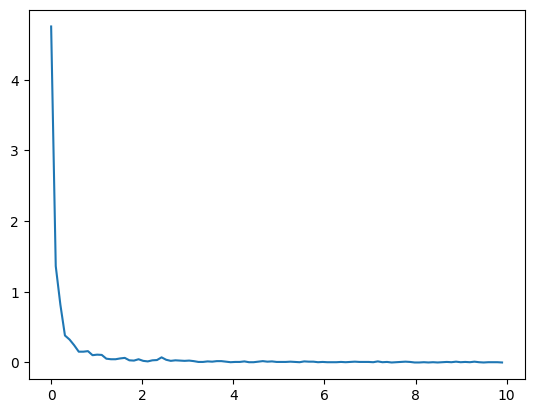

In [117]:
data = units['isi_violations']
bins = np.linspace(0,10,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

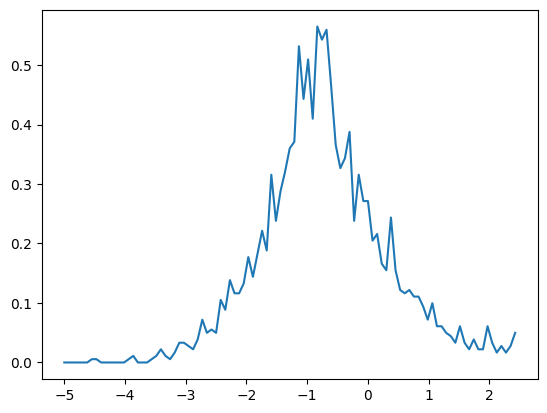

In [104]:
data = np.log10(units['isi_violations'])
bins = np.linspace(-5,2.5,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### SNR
*Signal-to-noise ratio*, or SNR, is another classic metric of unit quality. It measures the ratio of the maximum amplitude of the mean spike waveform to the standard deviation of the background noise on one channel.

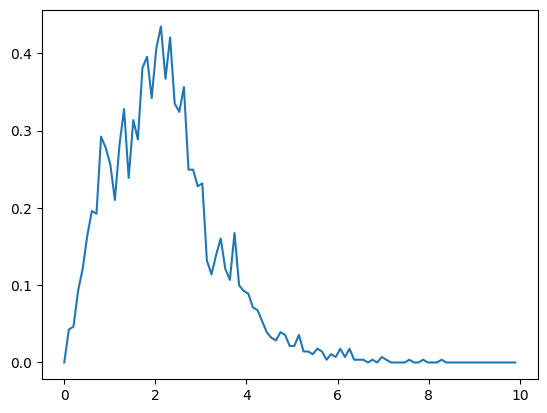

In [106]:
data = units['snr']
bins = np.linspace(0,10,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### Isolation Distance
*Isolation distance* is a metric based on the principal components (PCs) of a unit's waveforms. After the spike sorting step is complete, the waveforms for every spike are projected into a lower-dimensional principal component space. The higher the isolation distance, the more a unit is separated from its neighbors in PC space, and therefore the lower the likelihood that it's contamined by spikes from multiple units. For more information on this, read the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html#isolation_distance).

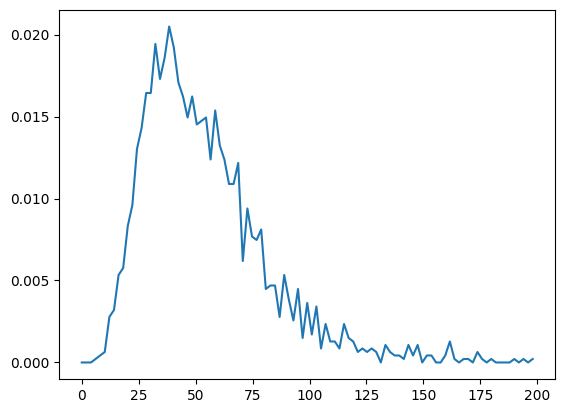

In [108]:
data = units['isolation_distance']
bins = np.linspace(0,200,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### d-prime
Like isolation distance, *d-prime* is another metric calculated for the waveform PCs. It uses linear discriminant analysis to calculate the separability of one unit's PC cluster and all of the others. A higher d-prime value indicates that the unit is better isolated from its neighbors.

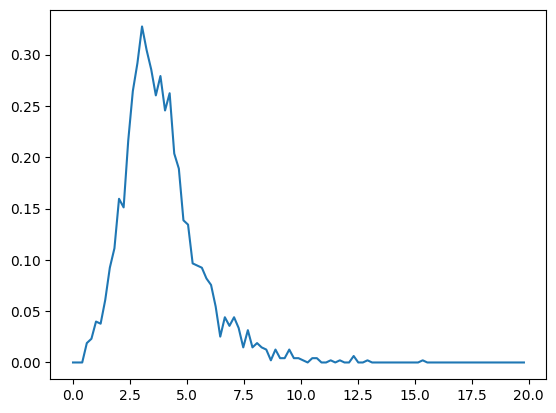

In [116]:
data = units['d_prime']
bins = np.linspace(0,20,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### Nearest-neighbors hit-rate
*Nearest-neighbors hit rate* is another PC-based quality metric. It's derived from the 'isolation' metric originally reported in Chung, Magland et al. (2017). This metric looks at the PCs for one unit and calculates the fraction of their nearest neighbors that fall within the same cluster. If a unit is highly contaminated, then many of the closest spikes will come from other units. Nearest-neighbors hit rate is nice because it always falls between 0 and 1, making it straightforward to compare across different datasets.

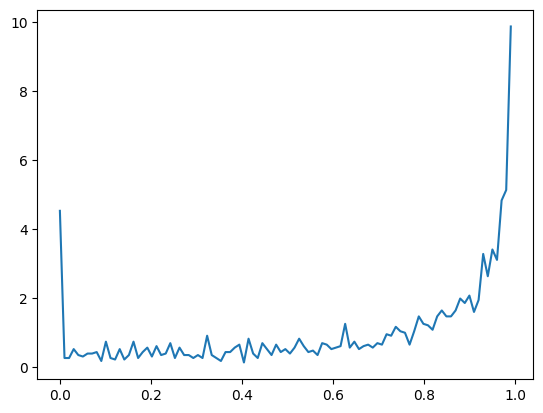

In [129]:
data = units['nn_hit_rate']
bins = np.linspace(0,1,100)
hist, bin_edges = np.histogram(data, bins=bins, density=True)

fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)

### Summary

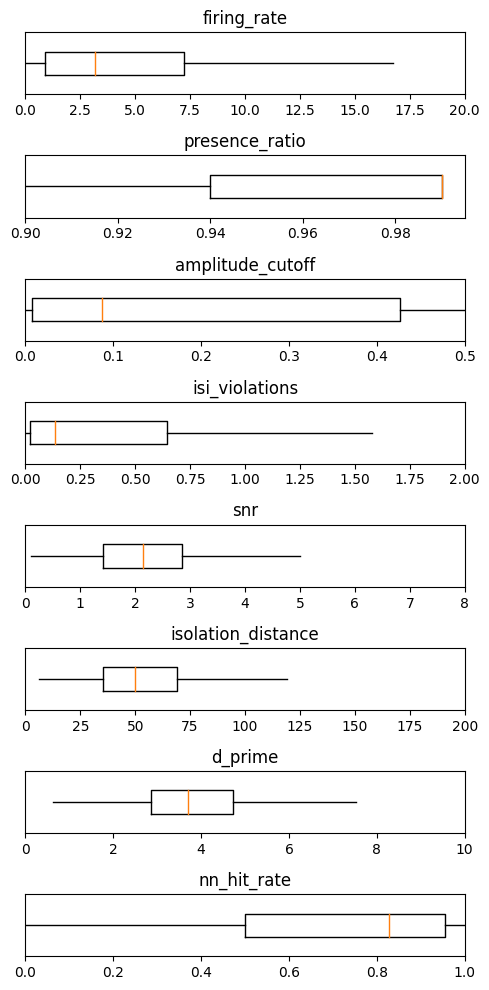

In [167]:
metrics = ['firing_rate', 'presence_ratio', 'amplitude_cutoff', 'isi_violations', 'snr', 'isolation_distance', 'd_prime', 
           'nn_hit_rate']
ranges = [[0,20], [0.9,0.995], [0,0.5], [0,2], [0,8], [0,200], [0,10], [0,1]]
_ = plt.figure(figsize=(5,10))

for idx, metric in enumerate(metrics):
    data = units[metric].values
    # remove NaNs
    data = data[np.invert(np.isnan(data))]

    plt.subplot(len(metrics),1,idx+1)
    plt.boxplot(data, showfliers=False, showcaps=False, vert=False)

    plt.ylim([0.8,1.2])
    plt.xlim(ranges[idx])
    plt.yticks([])
    
    plt.title(metric)

plt.tight_layout()